In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import time
import os
import sys
#sys.path.append("/home/jvkolomejtsev/dl/lib/python3.5/site-packages")

import portfolioopt as pfopt
import portfolio_rrl

import lasagne
from lasagne.layers import *

from agentnet.memory import RNNCell, LSTMCell, GRUCell

from portfolio_rrl import normalize_weights_symb
from collections import OrderedDict

## Dataset description

As dataset let's take 6 popular stock market indices for 8 years:
 - S&P 500,
 - Hang Seng,
 - CSI 300,
 - DJIA,
 - Nikkei 225,
 - Nifty 50.
  
The period is from July 2008 till August 2016: all in all 2005 trading days. We will split the data into train and test, train will be 75% and test 25%. We will fit our RRL model on train dataset and then compare it with other benchmarks and state-of-the art algorithms (mainly from PyOLPS package that was also implemented under this research project).

While training deep learning models considering plenty of features can give substancial profit. So let's use not only Closing price data, but also other features connected with the Index (all in all 19 features).

We will use these features:
 - Open, High, Low, and Close prices
 - MACD - moving average convergence divergence
 - CCI - commodity channel index
 - ATR - Average true range (volatility of price)
 - BOLL - Bollinger Band
 - EMA20 - exponential moving average for 20 days
 - MA5, MA10 - moving average for 5 and 10 days
 - MTM6, MTM12 - 6 and 12 month momentum
 - ROC - price rate of change (speed at which a stock's price is changing)
 - SMI - stochastic momentum index
 - WVAD - William's Variable Accumulation Distribution (buying and selling pressure)
 - US Dollar Index - macroeconomic variable
 - Interbank Offered Rate / Federal Fund Rate - macroeconomic variable (SHIBOR - Shanghai Interbank Offered Rate, HIBOR - Hong Kong Interbank Offered Rate)
 
To make the experiments closer to reality we will consider the commission rate for transactions. In all experiments it is equal to $0.01 \%$ both for selling and buying.

In [2]:
sheet_names = ['S&P500 Index Data', 'HangSeng Index Data', 'CSI300 Index Data', 
              'DJIA index Data', 'Nikkei 225 index Data', 'Nifty 50 index Data']


feature_names = [
    [
        'Close Price', 'CCI', 'SMI', 'Low Price', 'High Price', 'Open Price', 'Volume',
        'EMA20', 'ROC', 'WVAD', 'BOLL', 'ATR', 
        'MA5', 'MA10', 'MTM6', 'MTM12', 'MACD',
        'US Dollar Index', 'Federal Fund Rate'
    ],
    [
        'Closing Price', 'CCI', 'SMI', 'Low Price', 'High price', 'Open Price', 'Volume',
        'EMA20', 'ROC', 'WVAD', 'BOLL_MID', 'ATR', 
        'MA5', 'MA10', 'MTM6', 'MTM12', 'MACD', 
        'US Dollar Index', 'HIBOR'
    ],
    [
        'Closing Price', 'CCI', 'SMI', 'Low Price', 'High Price', 'Open Price', 'Volume',
        'EMA20', 'ROC', 'WVAD', 'BOLL','ATR',
        'MA5', 'MA10', 'MTM6','MTM12', 'MACD',
        'US Dollar Index', 'SHIBOR'
    ],
    [
        'Closing Price', 'CCI', 'SMI', 'Low Price','High price','Open Price', 'Volume',
         'EMA20', 'ROC', 'WVAD', 'BOLL_MID', 'ATR', 
        'MA5', 'MA10', 'MTM6', 'MTM12', 'MACD',
        'US dollar Index', 'Federal Fund Rate'
    ],
    [
        'Closing Price', 'CCI', 'SMI', 'Low Price', 'High price', 'Open Price', 'Volume',
        'EMA20', 'ROC', 'WVAD', 'BOLL_MID', 'ATR',
        'MA5',  'MA10', 'MTM6', 'MTM12', 'MACD',
         'US dollar Index', 'Interbank Offered Rate'
    ],
    [
        'Closing Price', 'CCI', 'SMI', 'Low price', 'High Price', 'Open Price', 'Volume',
        'EMA20', 'ROC', 'WVAD',  'BOLL_MID', 'ATR',
        'MA5', 'MA10', 'MTM6', 'MTM12', 'MACD', 
        'US dollar Index', 'Interbank Offered Rate'
    ]
]


start_indices = [1, 0, 1, 1, 1, 1]

In [3]:
def load_data(path, sheet_names, length=2007):
    data = []
    for i, sheet_name in enumerate(sheet_names):
        print("reading %s file ..." % sheet_name)
        df = pd.read_excel(path, sheet_name=sheet_name)
        data.append(df[feature_names[i]].iloc[start_indices[i]:start_indices[i] + length])
    data = np.stack(data, axis=1)
    return np.array(data, dtype=float)


def normalize_data(data):
    data_norm = data.copy()
    indices = np.argwhere(data_norm == 0)
    for x,y,z in indices:
        data_norm[x, y, z] = 1e-9
    data_norm = data_norm[1:] / data_norm[:-1] - 1
    return data_norm


def make_features_returns(data):
    X = data[:-1]
    y = data[1:,:,0]
    return X, y


def convert_ratio_to_price(data_ratio):
    data_price = np.ones(data_ratio.shape)
    for i in range(1, data_ratio.shape[0]):
        data_price[i] = data_price[i - 1] * data_ratio[i]
    return data_price


def train_val_test_split(features, returns, val_frac=0.1, test_frac=0.15):
    train_frac = 1 - val_frac - test_frac
    num_train = int(len(features) * train_frac)
    num_val = int(len(features) * val_frac)
    num_test = len(features) - num_train - num_val
    X_train = features[:num_train]
    y_train = returns[:num_train]
    X_val = features[num_train:num_train + num_val]
    y_val = returns[num_train:num_train + num_val]
    X_test = features[-num_test:]
    y_test = returns[-num_test:]
    return X_train, y_train, X_val, y_val, X_test, y_test


def plot_one_strategy(returns, title, label, save_path=None):
    plt.figure(figsize=(8, 8))
    plt.plot(returns, label=label, lw=2)
    plt.ylabel('Return', size=15)
    plt.xlabel('Trading day', size=15)
    plt.title(title, size=17)
    plt.legend(loc='lower right', prop={"size": 15})
    plt.grid(color='gray', linestyle='dashed')    
    if save_path is not None:
        plt.savefig(save_path + ".eps", bbox_inches='tight') # pdf
        plt.close()
    else:
        plt.show()


def plot_returns(X, y, models, base_model = False, eg_res=None, res_markowitz=None,
                 title="Returns", legend_loc='best', figsize=(12, 8), lw=2, save_path=None):
    if type(models) not in (list,tuple):
        models=[models]
    else:
        models = list(models)

    portfolios = {}
    for i,model in enumerate(models):
        name = "%s" % (model.name)
        portfolios[name] = model.predict(X, y=y)

    plt.figure(figsize=figsize)
    plt.title(title, size=18)
    plt.xlabel("Returns", size=15)
    plt.ylabel("Time", size=15)
    for model_name, weights in sorted(portfolios.items()):
        if model_name == 'RRL_with_DFSR_model_without_costs':
            cost_coefficient = 0
        else:
            cost_coefficient = 1e-4
        model_returns = portfolio_rrl.get_portfolio_returns_fin({"assets": y}, weights, 
                                                        cost_coefficient=cost_coefficient)
        sharpe = portfolio_rrl.sharpe_ratio_fin(model_returns)
        plt.plot(np.cumsum(model_returns), label='%s (sharpe=%.3f)' % (model_name,sharpe), lw=lw)
    
    if base_model:
        base_returns = portfolio_rrl.get_base_returns_fin(y,)
        base_sharpe = portfolio_rrl.sharpe_ratio_fin(base_returns)
        plt.plot(np.cumsum(base_returns), label='UCRP (sharpe=%.3f)' % (base_sharpe), lw=lw)
    if eg_res is not None:
        plt.plot(eg_res[0][1] - 1, label='EG (sharpe=%.3f)' % (eg_res[1]), lw=lw)
    
    if weights_markowitz is not None:
        plt.plot(res_markowitz[0], label='Markowitz (sharpe=%.3f)' % 
                                                (res_markowitz[1]), lw=lw)
    
    plt.legend(loc=legend_loc, prop={"size":12})
    plt.grid(color='gray', linestyle='dashed')
    
    if save_path is not None:
        plt.savefig(save_path + ".eps", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [4]:
path = 'RawData.xlsx'
data = load_data(path, sheet_names)

reading S&P500 Index Data file ...
reading HangSeng Index Data file ...
reading CSI300 Index Data file ...
reading DJIA index Data file ...
reading Nikkei 225 index Data file ...
reading Nifty 50 index Data file ...


In [5]:
data_norm = normalize_data(data)

In [6]:
X, y = make_features_returns(data_norm)

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y, val_frac=0., test_frac=0.25)

## Baselines:

While fitting our RRL model we will compare it with 3 baselines: Uniform Constant Rebalanced Portfolio (UCRP), Exponential Gradient (EG) and Markowitz models.

## Uniform Constant Rebalanced Portfolio (UCRP)

In [8]:
weights_ucrp = np.ones(X.shape[1]) / X.shape[1]

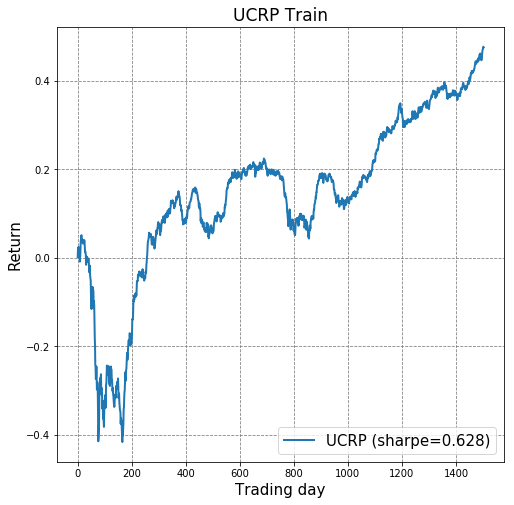

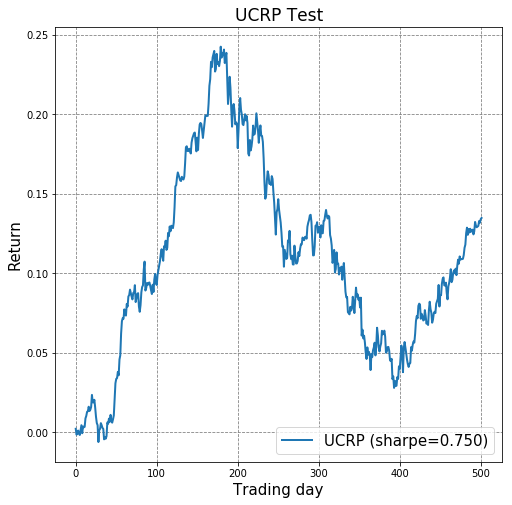

In [9]:
pred_returns = y_train.dot(weights_ucrp)
ucrp_sharpe = portfolio_rrl.sharpe_ratio_fin(pred_returns)
plot_one_strategy(pred_returns.cumsum(), 'UCRP Train', 'UCRP (sharpe=%.3f)' % ucrp_sharpe)

pred_returns = y_test.dot(weights_ucrp)
ucrp_sharpe = portfolio_rrl.sharpe_ratio_fin(pred_returns)
plot_one_strategy(pred_returns.cumsum(), 'UCRP Test', 'UCRP (sharpe=%.3f)' % ucrp_sharpe)

## Exponential Gradient (EG)

In [10]:
from pyolps.strategy import eg
tc = 1e-4
opts = {'display_interval': 1000}

In [11]:
res_eg_train = eg.eg_run(y_train + 1, tc, opts)
res_eg_test = eg.eg_run(y_test + 1, tc, opts)

100%|██████████| 502/502 [00:00<00:00, 36938.66it/s]


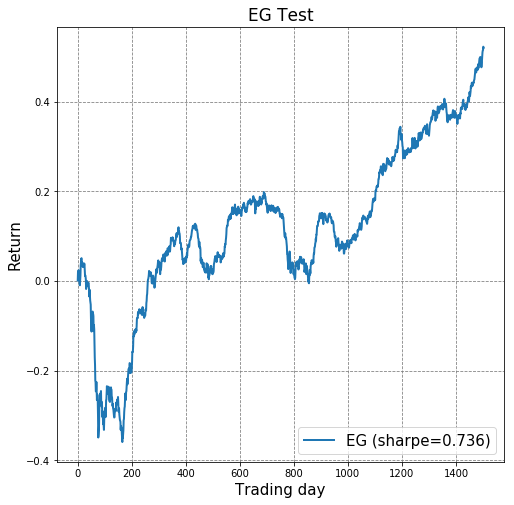

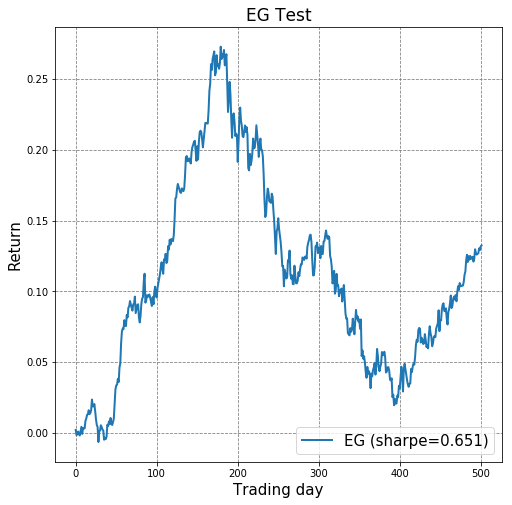

In [12]:
pred_cumsum = res_eg_train[1] - 1
pred_cumsum[1:] -= pred_cumsum[:-1].copy()
eg_sharpe_train = portfolio_rrl.sharpe_ratio_fin(pred_cumsum)
plot_one_strategy((res_eg_train[1] - 1), 'EG Test', 'EG (sharpe=%.3f)' % eg_sharpe_train)

pred_cumsum = res_eg_test[1] - 1
pred_cumsum[1:] -= pred_cumsum[:-1].copy()
eg_sharpe_test = portfolio_rrl.sharpe_ratio_fin(pred_cumsum)
plot_one_strategy((res_eg_test[1] - 1), 'EG Test', 'EG (sharpe=%.3f)' % eg_sharpe_test)

## Markowitz model

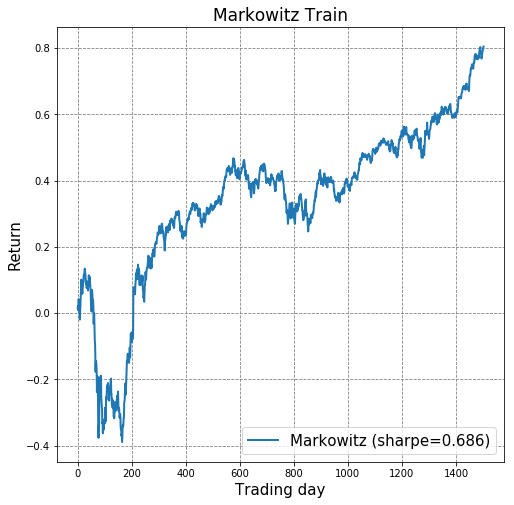

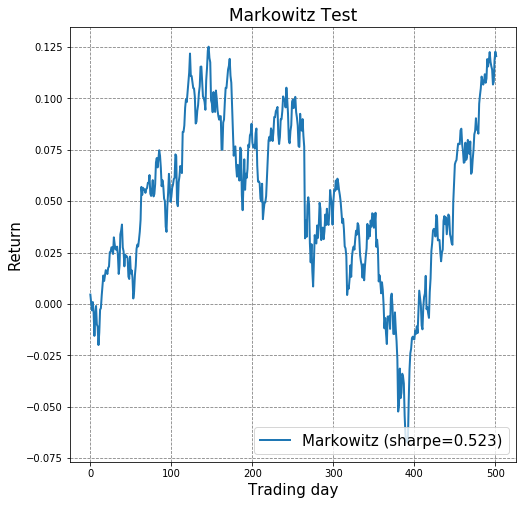

In [13]:
returns_train = pd.DataFrame(y_train.astype(np.double))
cov_mat = returns_train.cov()
avg_rets = returns_train.mean(axis = 0)
target_ret = avg_rets.quantile(0.95)
weights_markowitz = pfopt.markowitz_portfolio(cov_mat, avg_rets, target_ret)
returns_pred = returns_train.dot(weights_markowitz)
mark_sharpe = portfolio_rrl.sharpe_ratio_fin(returns_pred)
plot_one_strategy(returns_pred.cumsum(), 'Markowitz Train', 'Markowitz (sharpe=%.3f)' % mark_sharpe)
res_markowitz_train = (returns_pred.cumsum(), mark_sharpe)

returns_test = pd.DataFrame(y_test.astype(np.double))
returns_pred = returns_test.dot(weights_markowitz)
mark_sharpe = portfolio_rrl.sharpe_ratio_fin(returns_pred)
plot_one_strategy(returns_pred.cumsum(), 'Markowitz Test', 'Markowitz (sharpe=%.3f)' % mark_sharpe)

res_markowitz_test = (returns_pred.cumsum(), mark_sharpe)

## Recurrent Reinforcement Learning (RRL)

Related articles:
"Performance functions and reinforcement learning for trading systems and portfolios" (Moody J.)
"FX trading via recurrent reinforcement learning" (by Gold C, 2003)
"Regime-switching recurrent reinforcement learning in automated trading" (Maringer D., Ramtohul T., 2011)

Let's write the main formulas that we will need to use during the implementations.

Denote: $z_t$ - price of the asset at the time $t$.

We will use this values as the input data:
$$r_t = \frac{z_t}{z_{t - 1}} - 1$$

The decision function:
$$F_t = \text{tanh} \big( \sum_{i = 0}^{m - 1} w_i(t)r_{t - i} + w_m(t) F_{t - 1} + w_{m + 1} \nu \big)$$

If $F_t > 0$ then a trader is in the LONG position (is buying the asset), if $F_t < 0$  then a trader is in the SHORT position (is selling the asset). $w_i$ are the parameters that are needed to optimize. And $\nu$ is the bias.

The rate of return of the asset could be computed like this:
$$R_t = r_t * F_t$$

As the optimizing functional let's take the Sharpe Ratio:
$$S_T = \frac{\hat{R}_T}{\sigma(R_T)},$$
where $\hat{R}_T = \frac{1}{T} \sum_{k = 0}^T R_k$, $\sigma(R_t) = \sqrt{\frac{1}{T} \sum_{k = 0}^T (R_k - \hat{R}_T)^2}$

For reinforcement learning I will use a popular **agentnet** library: https://github.com/yandexdataschool/AgentNet which is  a lightweight library to build and train deep reinforcement learning and custom recurrent networks using Theano+Lasagne Deep Learning framework.

As deep learning architecture I will use 2 GRU cells with 128 units each and 2 Dense layers: before 1st and after 2nd GRUs.

In [14]:
from portfolio_rrl import PortfolioNN
from theano import tensor as T

from agentnet import Recurrence

In [15]:
def make_step_rrl(n_instruments, n_features, n_gru0=128, n_gru1=128, grad_clip=5.,):
    
    class step_rrl:
        inp = InputLayer((None, n_instruments, n_features), name='tick features')
        inp_batch = ReshapeLayer(inp, (-1, 1, n_features))
        
        dense0 = DenseLayer(inp, 256, nonlinearity=lasagne.nonlinearities.tanh)

        prev_gru0 = InputLayer((None, n_gru0), name='gru0')       
        gru0 = GRUCell(prev_gru0, dense0, grad_clipping=grad_clip)

        prev_gru1 = InputLayer((None, n_gru1), name='gru1')
        gru1 = GRUCell(prev_gru1, [flatten(gru0)], grad_clipping=grad_clip)
        portfolio = DenseLayer(gru1, num_units = n_instruments,nonlinearity=normalize_weights_symb)

        memory_dict = OrderedDict({
            gru0: prev_gru0,
            gru1: prev_gru1,
        })

    return step_rrl

In [16]:
import portfolio_rrl
from portfolio_rrl import PortfolioNN
n_instruments,n_features = X.shape[-2:]

agent_step_rrl = make_step_rrl(n_instruments,n_features)

In [17]:
from theano import tensor as T
input_var = T.tensor4('input[batch,tick,instr,features]')
instr_returns = T.tensor3('delta r[batch,tick,instr]')
l_in = InputLayer([None, None, n_instruments, n_features], input_var=input_var)

In [18]:
from agentnet import Recurrence
rec_rrl = Recurrence(state_variables=agent_step_rrl.memory_dict,
                     input_sequences={agent_step_rrl.inp: l_in},
                     tracked_outputs=[agent_step_rrl.portfolio],
                     unroll_scan=False)

portfolios_seq_rrl = rec_rrl[agent_step_rrl.portfolio]

portfolio_nn_rrl = PortfolioNN([input_var],
                               [instr_returns],
                               [portfolios_seq_rrl],
                               name = 'RRL_model',
                               updates_callback=rec_rrl.get_automatic_updates)

### Train

In [93]:
num_epochs = 2
for epoch in range(num_epochs):
    start_time = time.time()
    portfolio_nn_rrl.fit(X_train, y_train, nb_epochs=10, seq_len=20)
    portfolio_nn_rrl.update_metrics(X_train, {"assets": y_train}, 'train ')
    model_returns = portfolio_nn_rrl.update_metrics(X_test, {"assets": y_test},'test ')
    cur_sum = model_returns.cumsum()[-1]
    print("sum: %f" % cur_sum)
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

train sharpes =  0.628394878749558 4.4698646692388575
test sharpes =  0.750468061567823 0.8276379901984202
sum: 0.197166
Epoch 1 of 2 took 0.776s
train sharpes =  0.628394878749558 5.368225922047385
test sharpes =  0.750468061567823 1.1365936028228334
sum: 0.251197
Epoch 2 of 2 took 0.775s


In [33]:
portfolio_nn_rrl.save('model_rrl.pcl', True)

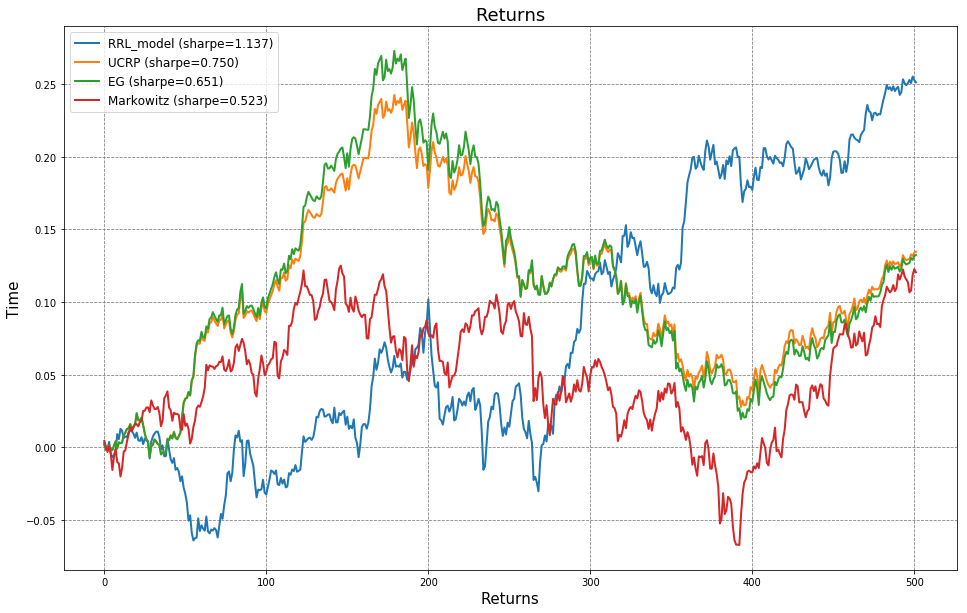

In [96]:
plot_returns(X_test, y_test, portfolio_nn_rrl, True, (res_eg_test, eg_sharpe_test), res_markowitz_test,
             title="Returns", legend_loc='best', figsize=(16, 10))
plot_returns(X_test, y_test, portfolio_nn_rrl, True, (res_eg_test, eg_sharpe_test), res_markowitz_test,
             title="Returns", legend_loc='best', figsize=(16, 10), save_path='plots/rrl_first')

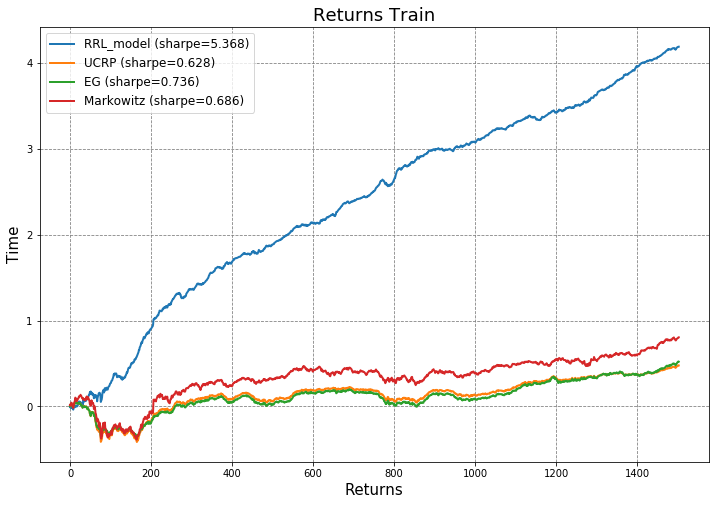

In [106]:
plot_returns(X_train, y_train, portfolio_nn_rrl, True, (res_eg_train, eg_sharpe_train), 
             res_markowitz_train, title="Returns Train", legend_loc='best', figsize=(12, 8))
plot_returns(X_train, y_train, portfolio_nn_rrl, True, (res_eg_train, eg_sharpe_train), 
             res_markowitz_train, title="Returns Train", legend_loc='best', figsize=(12, 8),
             save_path='plots/rrl_train')

We can see that the RLL model can achieve the quality higher than baselines by both metrics: Sharpe and Total return. However, there is still things to improve, for example, to use Differential Sharpe Ratio.

Let's improve the model!

### RRL with Differential Sharpe Ratio (DSR)

Let's improve the previous RRL model by taking the idea of differential sharpe ratio from the article "FX trading via recurrent reinforcement learning" (by Gold C, 2003).

The decision function:
$$F_t = \text{sign} ( \sum_{i = 0}^{m - 1} w_i(t)r_{t - i} + w_m(t) F_{t - 1} + w_{m + 1} \nu )$$

As an optimization function we will take exponential moving average (EMA):

$$EMA_t = \alpha p_t + (1 - \alpha) EMA_{t - 1},$$
where $p_t$ is the value of the function at the moment $t$ and $\alpha \in [0, 1]$.

In [19]:
def make_step_rrl_dsr(n_instruments, n_features, n_gru0=128, grad_clip=5.):

    class step_rrl_dsr:
        inp = InputLayer((None, n_instruments, n_features), name='tick features')
        inp_batch = ReshapeLayer(inp, (-1, 1, n_features))
        prev_grus = InputLayer((None, n_instruments, n_features))
        prev_grus_batch = ReshapeLayer(prev_grus, (-1, n_features))
        new_grus_batch = GRUCell(prev_grus_batch, inp_batch)
        new_grus = ReshapeLayer(new_grus_batch, (-1, n_instruments, n_features))

        prev_gru0 = InputLayer((None, n_gru0), name='prev gru0')
        gru0 = GRUCell(prev_gru0, new_grus, grad_clipping=grad_clip)
        
        portfolio = DenseLayer(gru0, n_instruments, nonlinearity=normalize_weights_symb)

        memory_dict = OrderedDict({
            new_grus : prev_grus,
            gru0 : prev_gru0,
        })
    return step_rrl_dsr

In [20]:
n_instruments,n_features = X_train.shape[-2:]

agent_step_rrl_dsr = make_step_rrl_dsr(n_instruments,n_features)

In [21]:
input_var = T.tensor4('input[batch,tick,instr,features]')
instr_returns = T.tensor3('delta r[batch,tick,instr]')
l_in = InputLayer([None, None, n_instruments, n_features], input_var=input_var)

In [22]:
rec_rrl_dsr = Recurrence(state_variables=agent_step_rrl_dsr.memory_dict,
                               input_sequences={agent_step_rrl_dsr.inp: l_in},
                               tracked_outputs=[agent_step_rrl_dsr.portfolio],
                               unroll_scan=False)

portfolios_seq_rrl_dsr = rec_rrl_dsr[agent_step_rrl_dsr.portfolio]

In [23]:
portfolio_nn_rrl_dsr = PortfolioNN([input_var],
                                         [instr_returns],
                                         [portfolios_seq_rrl_dsr],
                                         name = 'RRL_with_DFSR_model',
                                         updates_callback=rec_rrl_dsr.get_automatic_updates)

### Train

In [47]:
num_epochs = 2
for epoch in range(num_epochs):
    start_time = time.time()
    portfolio_nn_rrl_dsr.fit(X_train, y_train, nb_epochs=10, seq_len=20)
    portfolio_nn_rrl_dsr.update_metrics(X_train, {"assets": y_train}, 'train ')
    model_returns = portfolio_nn_rrl_dsr.update_metrics(X_test, {"assets": y_test},'test ')
    cur_sum = model_returns.cumsum()[-1]
    print("test cumsum: %f" % cur_sum)
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

train sharpes =  0.628394878749558 2.4009605085181014
test sharpes =  0.750468061567823 1.393703666950119
test cumsum: 0.297491
Epoch 1 of 30 took 1.048s
train sharpes =  0.628394878749558 3.372463226228851
test sharpes =  0.750468061567823 1.969383316837261


In [48]:
portfolio_nn_rrl_dsr.save('model_rrl_dsr.pcl', True)

In [109]:
portfolio_nn_rrl_dsr.load('model_rrl_dsr.pcl')

In [110]:
model_returns = portfolio_nn_rrl_dsr.update_metrics(X_test, {"assets": y_test},'test ')

test sharpes =  0.750468061567823 1.9693833168372612


In [111]:
print("test return: ", model_returns.cumsum()[-1])

test return:  0.43004697332546543


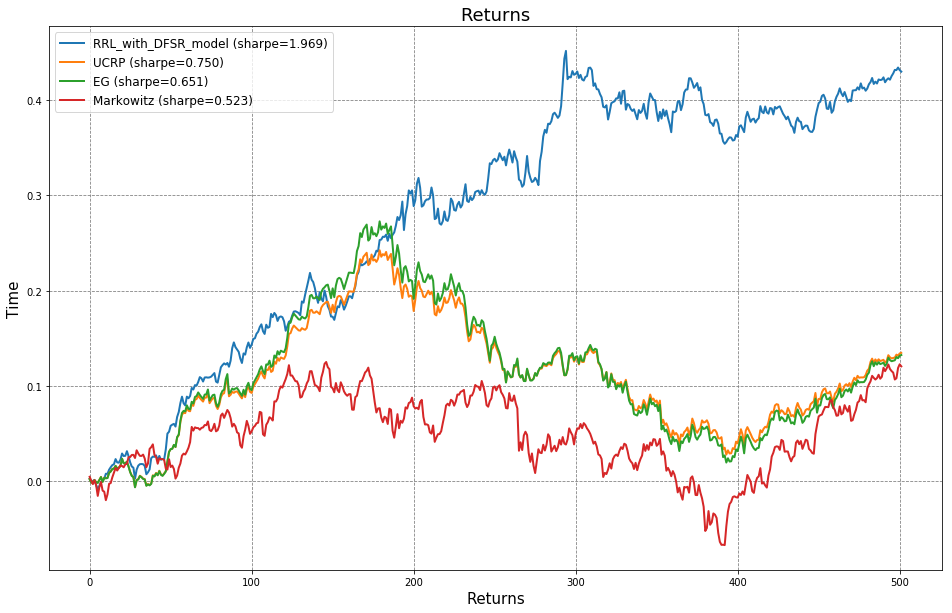

In [112]:
plot_returns(X_test, y_test, portfolio_nn_rrl_dsr, True, (res_eg_test, eg_sharpe_test), res_markowitz_test,
             title="Returns", legend_loc='best', figsize=(16, 10))
plot_returns(X_test, y_test, portfolio_nn_rrl_dsr, True, (res_eg_test, eg_sharpe_test), res_markowitz_test,
             title="Returns", legend_loc='best', figsize=(16, 10), save_path='plots/rrl_with_dfsr')

We can see that when using RRL with DSR we get very good quality, much better than our baselines on both metrics. 

###  RRL with DSR results

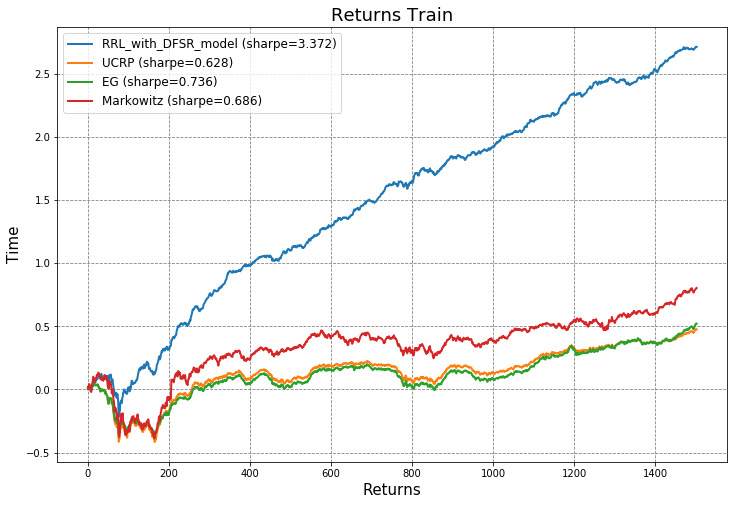

In [112]:
plot_returns(X_train, y_train, portfolio_nn_rrl_dsr, True, (res_eg_train, eg_sharpe_train), 
             res_markowitz_train, title="Returns Train", legend_loc='best', figsize=(12, 8))
plot_returns(X_train, y_train, portfolio_nn_rrl_dsr, True, (res_eg_train, eg_sharpe_train), 
             res_markowitz_train, title="Returns Train", legend_loc='best', figsize=(12, 8),
             save_path='plots/rrl_with_dfsr_train')

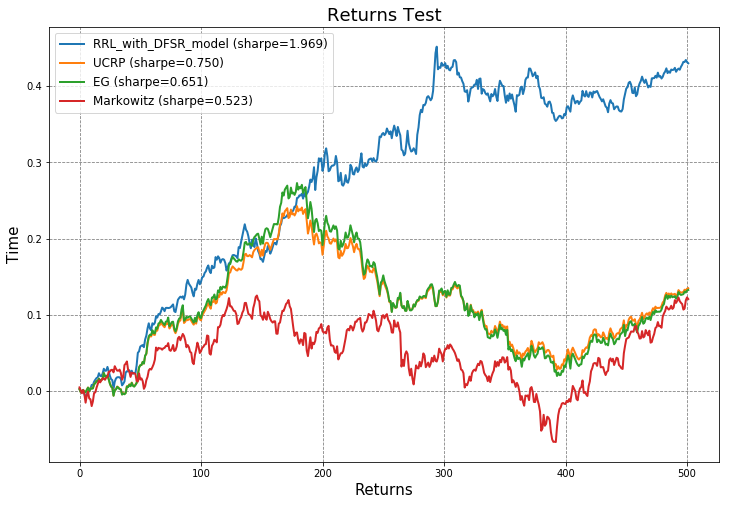

In [104]:
plot_returns(X_test, y_test, portfolio_nn_rrl_dsr, True, (res_eg_test, eg_sharpe_test), res_markowitz_test,
             title="Returns Test", legend_loc='upper left', figsize=(12, 8))

We can see that RRL model with differential sharpe ratio strongly outperforms our baseline models. It has both the best sharpe ratio ($1.969$) and total return ($0.43$) on test dataset.

## Comparison with other strategies (from PyOlps)

Let's compare RRL strategy with previously implemented strategies from PyOlps. Namely, we will compare RRL strategy with these benchmark and some state-of-the-art algorithms:

1) Bechmarks:
- Uniform BAH (UBAH)
- Uniform CRP (UCRP)
- Best Constant Rebalanced Portfolio (BCRP)
- Best Stock

2) Follow-the-Winner:
- Universal Portfolio (UP)
- Exponential Gradient (EG)
- Online Newton Step (ONS)

3) Follow-the-Loser:
- Anti Correlation (Anticor) in 2 variants: BAH(Anticor) and BAH(Anticor(Anticor))
- Passive Aggressive Mean Reversion (PAMR)
- Online Moving Average Reversion (OLMAR) in 2 variants: OLMAR-1 and OLMAR-2
- Robust Median Reversion (RMR)

4) Pattern-Matching Approaches:
- Nonparametric Nearest Neighbor Log-optimal (BNN)
- Correlation-driven Nonparametric Learning

In [81]:
def plot_results(results, strategy_set=None, figsize=(12, 10), title='', 
                 bbox_to_anchor=(1.05, 1), loc=2, legend_size=14,
                 semilogy_flag=False, lws=(1, 3), save_path=None):
    if semilogy_flag:
        plot_func = plt.semilogy
    else:
        plot_func = plt.plot
    
    plt.figure(figsize=figsize)
    
    for strategy_name, res in results.items():
        if strategy_set is not None:
            if not strategy_name in strategy_set:
                continue
        if strategy_name == 'RRL':
            lw = lws[1]
            plot_func(res[1], label=strategy_name, lw=lw, c='tab:red')
        else:
            lw = lws[0]
            plot_func(res[1], label=strategy_name, lw=lw)
    plt.title(title, size=20)
    plt.xlabel("Time", size=15)
    ylabel = 'Total Return'
    if semilogy_flag:
        ylabel += ' (log-scale)'
    plt.ylabel(ylabel, size=15)
    plt.legend(prop={'size': legend_size}, bbox_to_anchor=bbox_to_anchor, loc=loc, borderaxespad=0.)
    plt.grid(color='lightgray', linestyle='dashed')
    if save_path is not None:
        plt.savefig(save_path + ".eps", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [82]:
from pyolps import utils
from pyolps.strategy import *

In [83]:
y_test_pyolps = y_test + 1
tc = 1e-4
opts = {'display_interval': 1000}

In [84]:
res_ubah = bah.bah_run(y_test_pyolps, tc, opts)

res_bcrp = bcrp.bcrp_run(y_test_pyolps, tc, opts)
res_best = best_stock.best_stock_run(y_test_pyolps, tc, opts)

res_ucrp = crp.crp_run(y_test_pyolps, tc, opts)

res_up = up.up_run(y_test_pyolps, tc, opts, verbose=True)

 10%|▉         | 48/502 [00:00<00:00, 474.64it/s]

Parameters [tc: 0.000100].

day	 Daily Return	 Total return



100%|██████████| 502/502 [00:00<00:00, 510.29it/s]


In [85]:
res_eg = eg.eg_run(y_test_pyolps, tc, opts)
res_ons = ons.ons_run(y_test_pyolps, tc, opts)

100%|██████████| 502/502 [00:00<00:00, 1304.33it/s]


In [86]:
res_olmar1 = olmar.olmar_run(y_test_pyolps, tc, opts, variant=1, window=5, epsilon=10)
res_olmar2 = olmar.olmar_run(y_test_pyolps, tc, opts, variant=2, alpha=0.5, epsilon=10)
res_rmr = rmr.rmr_run(y_test_pyolps, tc, opts, epsilon=10, window=5)

100%|██████████| 502/502 [00:00<00:00, 574.30it/s]


In [87]:
res_anticor = anticor.anticor_run(y_test_pyolps, tc, opts)
res_anticor_anticor = anticor.anticor_anticor_run(y_test_pyolps, tc, opts)

100%|██████████| 502/502 [00:05<00:00, 95.62it/s] 


In [88]:
res_pamr = pamr.pamr_run(y_test_pyolps, tc, opts)

100%|██████████| 502/502 [00:00<00:00, 7974.48it/s]


In [89]:
res_bnn = bnn.bnn_run(y_test_pyolps, tc, opts)

100%|██████████| 502/502 [01:59<00:00,  4.21it/s]


In [90]:
res_corn = corn.corn_run(y_test_pyolps, tc, opts)

100%|██████████| 502/502 [00:08<00:00, 60.31it/s] 


In [91]:
results = {
    'UBAH': res_ubah, 'BCRP': res_bcrp, 'Best Stock': res_best,
    'UCRP': res_ucrp, 'UP': res_up, 'EG': res_eg,
    'ONS': res_ons, 'Anticor': res_anticor, 'Anticor(Anticor)': res_anticor_anticor,
    'PAMR': res_pamr, 'OLMAR-1': res_olmar1, 'OLMAR-2': res_olmar2,
    'RMR': res_rmr, 'CORN': res_corn, 'BNN': res_bnn,
    'RRL': (0, model_returns.cumsum() + 1)
}

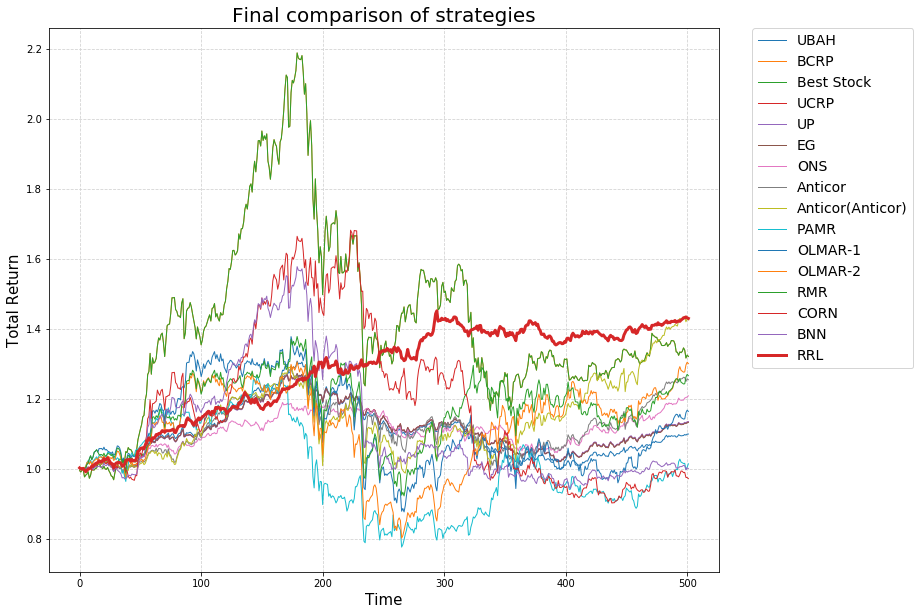

In [92]:
plot_results(results, figsize=(12, 10), title="Final comparison of strategies")
plot_results(results, figsize=(12, 10), title="Final comparison of strategies", save_path='plots/final')

## Results

We can see on the plot "Final comparison of strategies", starting from around 2/3 period of our test dataset, RRL strategy (thick	purple line) outperforms all other strategies. Moreover, we see that, unlike many other strategies, RRL is smooth and straightforward, it doesn't have any big jumps. This is also confirmed by the high Sharpe ratio: $1.969$ which is almost 2 times higher than the predecessor ONS: $1.016$ (the dataframe is below).

This is a very big advantage of RRL strategy as having low risks is one of the main priorities of traders.

Other algorithms that are in the top (Total Return) at the end of test period are: Anticor(Anticor), Best Stock, OLMAR-1, OLMAR-2, RMR, Anticor (listed in the order of their descending quality).

That shows us that using reinforcement learning with deep learning for solving portfolio selection task can give very profitable and stable results.

In [93]:
def compute_sharpe_results(results):
    results_sharpe = {}
    for k, val in results.items():
        pred_cumsum = np.array(val[1]) - 1
        pred_cumsum[1:] -= pred_cumsum[:-1].copy()        
        results_sharpe[k] = portfolio_rrl.sharpe_ratio_fin(pred_cumsum)
    return results_sharpe

results_sharpe = compute_sharpe_results(results)

items = results_sharpe.items()
strat_names = [x[0] for x in items]
sharpe_values = [x[1] for x in items]
returns = [results[x][1][-1] for x in results_sharpe]
sharpe_dict = {'strategy': strat_names, 'sharpe': sharpe_values, 'returns': returns}
sharpe_df = pd.DataFrame(sharpe_dict)[['strategy', 'sharpe', 'returns']]

In [94]:
sharpe_df.sort_values('sharpe', ascending=False)

,strategy,sharpe,returns
15,RRL,1.969383,1.430047
6,ONS,1.016901,1.208643
8,Anticor(Anticor),0.840856,1.425623
4,UP,0.666212,1.135017
3,UCRP,0.661377,1.134104
5,EG,0.650659,1.132446
7,Anticor,0.594237,1.254682
11,OLMAR-2,0.488413,1.300776
0,UBAH,0.443488,1.099442
12,RMR,0.396724,1.266272


In [95]:
for x in sharpe_df.sort_values('sharpe', ascending=False).itertuples():
    print('%s & %f & %f \\\\' % (x.strategy, x.sharpe, x.returns))

RRL & 1.969383 & 1.430047 \\
ONS & 1.016901 & 1.208643 \\
Anticor(Anticor) & 0.840856 & 1.425623 \\
UP & 0.666212 & 1.135017 \\
UCRP & 0.661377 & 1.134104 \\
EG & 0.650659 & 1.132446 \\
Anticor & 0.594237 & 1.254682 \\
OLMAR-2 & 0.488413 & 1.300776 \\
UBAH & 0.443488 & 1.099442 \\
RMR & 0.396724 & 1.266272 \\
BCRP & 0.322003 & 1.321177 \\
Best Stock & 0.322003 & 1.321177 \\
OLMAR-1 & 0.250928 & 1.164077 \\
PAMR & 0.026447 & 1.014283 \\
BNN & 0.001162 & 1.000596 \\
CORN & -0.039490 & 0.971911 \\


## LSTM vs. GRU

In [65]:
def make_step_rrl_dsr_lstm(n_instruments, n_features, n_lstm0=128, grad_clip=5.):

    class step_rrl_dsr:
        inp = InputLayer((None, n_instruments, n_features), name='tick features')
        inp_batch = ReshapeLayer(inp, (-1, 1, n_features))
        
        prev_lstm_cell = InputLayer((None, n_instruments, n_features))
        prev_lstm_cell_batch = ReshapeLayer(prev_lstm_cell, (-1, n_features))
        
        prev_lstm_hid = InputLayer((None, n_instruments, n_features))
        prev_lstm_hid_batch = ReshapeLayer(prev_lstm_hid, (-1, n_features))
        
        new_lstm_cell_batch, new_lstm_hid_batch = LSTMCell(prev_lstm_cell_batch, prev_lstm_hid_batch, inp_batch)
        new_lstm_cell = ReshapeLayer(new_lstm_cell_batch, (-1, n_instruments, n_features))
        new_lstm_hid = ReshapeLayer(new_lstm_hid_batch, (-1, n_instruments, n_features))

        prev_lstm_cell0 = InputLayer((None, n_lstm0), name='prev lstm cell0')
        prev_lstm_hid0 = InputLayer((None, n_lstm0), name='prev lstm hid0')
        
        lstm_cell, lstm_hid = LSTMCell(prev_lstm_cell0, prev_lstm_hid0, new_lstm_cell, grad_clipping=grad_clip)
        
        portfolio = DenseLayer(lstm_cell, n_instruments, nonlinearity=normalize_weights_symb)

        memory_dict = OrderedDict({
            new_lstm_cell : prev_lstm_cell,
            new_lstm_hid : prev_lstm_hid,
            lstm_cell : prev_lstm_cell0,
            lstm_hid : prev_lstm_hid0
        })
    return step_rrl_dsr

In [66]:
n_instruments,n_features = X.shape[-2:]

agent_step_rrl_lstm = make_step_rrl_dsr_lstm(n_instruments,n_features)

In [67]:
input_var_lstm = T.tensor4('input[batch,tick,instr,features]')
instr_returns_lstm = T.tensor3('delta r[batch,tick,instr]')
l_in = InputLayer([None, None, n_instruments, n_features], input_var=input_var_lstm)

In [68]:
rec_rrl_dsr_lstm = Recurrence(state_variables=agent_step_rrl_lstm.memory_dict,
                               input_sequences={agent_step_rrl_lstm.inp: l_in},
                               tracked_outputs=[agent_step_rrl_lstm.portfolio],
                               unroll_scan=False)

portfolios_seq_rrl_dsr_lstm = rec_rrl_dsr_lstm[agent_step_rrl_lstm.portfolio]

In [69]:
portfolio_nn_rrl_dsr_lstm = PortfolioNN([input_var_lstm],
                                         [instr_returns_lstm],
                                         [portfolios_seq_rrl_dsr_lstm],
                                         name = 'RRL_with_DFSR_model',
                                         updates_callback=rec_rrl_dsr_lstm.get_automatic_updates)

In [70]:
num_epochs = 2
for epoch in range(num_epochs):
    start_time = time.time()
    portfolio_nn_rrl_dsr_lstm.fit(X_train, y_train, nb_epochs=10, seq_len=20)
    portfolio_nn_rrl_dsr_lstm.update_metrics(X_train, {"assets": y_train}, 'train ')
    model_returns_lstm = portfolio_nn_rrl_dsr_lstm.update_metrics(X_test, {"assets": y_test},'test ')
    cur_sum = model_returns_lstm.cumsum()[-1]
    print("test cumsum: %f" % cur_sum)
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

train sharpes =  0.628394878749558 2.219630918288217
test sharpes =  0.750468061567823 1.3695466178645028
test cumsum: 0.272790
Epoch 1 of 2 took 0.614s
train sharpes =  0.628394878749558 3.147002449118296
test sharpes =  0.750468061567823 1.799644534434154
test cumsum: 0.377632
Epoch 2 of 2 took 0.622s


In [71]:
portfolio_nn_rrl_dsr_lstm.save('model_rrl_dsr_lstm.pcl', True)

In [72]:
model_returns_lstm = portfolio_nn_rrl_dsr_lstm.update_metrics(X_test, {"assets": y_test},'test ')

test sharpes =  0.750468061567823 1.799644534434154


In [73]:
print("test return lstm: ", model_returns_lstm.cumsum()[-1])

test return lstm:  0.3776318163183618


In [98]:
results_lstm_gru = {
    'RRL GRU': (0, model_returns.cumsum() + 1),
    'RRL LSTM': (0, model_returns_lstm.cumsum() + 1)
}

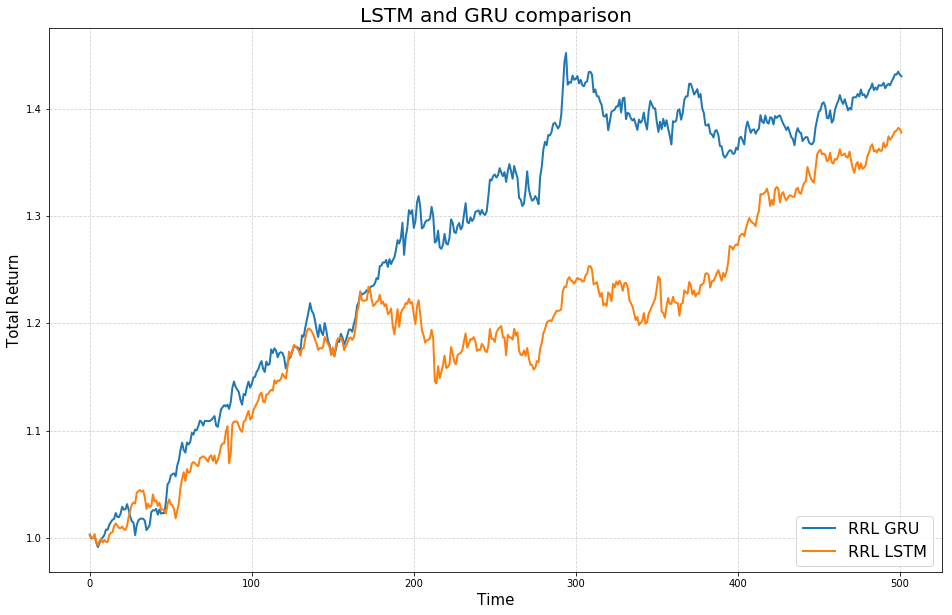

In [99]:
plot_results(results_lstm_gru, figsize=(16, 10), title="LSTM and GRU comparison", lws=(2, 2), 
             bbox_to_anchor=(0.99, 0.01), loc=4, legend_size=16)
plot_results(results_lstm_gru, figsize=(16, 10), title="LSTM and GRU comparison", lws=(2, 2), 
             bbox_to_anchor=(0.99, 0.01), loc=4, legend_size=16, save_path='plots/lstm_gru')

In [103]:
results_sharpe = compute_sharpe_results(results_lstm_gru)

items = results_sharpe.items()
strat_names = [x[0] for x in items]
sharpe_values = [x[1] for x in items]
returns = [results_lstm_gru[x][1][-1] for x in results_sharpe]
sharpe_dict = {'strategy': strat_names, 'sharpe': sharpe_values, 'returns': returns}
sharpe_df = pd.DataFrame(sharpe_dict)[['strategy', 'sharpe', 'returns']]

sharpe_df.sort_values('sharpe', ascending=False)

,strategy,sharpe,returns
0,RRL GRU,1.969383,1.430047
1,RRL LSTM,1.799645,1.377632


We can see that GRU has slightly better performance than LSTM.